In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

import numpy as np

from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")

In [3]:
# Initialize IRIS client
client = Client("IRIS")

# set our date range
starttime = UTCDateTime('2018-4-1')
endtime = UTCDateTime('2018-8-31')

POHA = client.get_stations(network="IU", station="POHA", 
                           starttime=starttime, endtime=endtime,
                          level='response')

In [3]:
events = client.get_events(starttime=starttime, endtime=endtime, 
                  latitude=19.76, longitude=-155.53,
                  maxradius=1, minmagnitude=1.5
                 )

In [9]:
events.write('hawaii_Apr-Aug-2018_mag1.5_POHA_catalog.xml', format='QUAKEML')

In [4]:
events = obspy.read_events('hawaii_Apr-Aug-2018_mag1.5_POHA_catalog.xml', format='QUAKEML')

## Estimate the arrival time for each quake at POHA and 

In [17]:
class ArrivalTime():
    def __init__(self, station):
        self.stalat = station.latitude
        self.stalong = station.longitude
        #self.stadepth = station.depth
        self.model = TauPyModel(model="iasp91")
        
    def calc_arrival_time(self, event):
        eventlat = event.origins[0].latitude
        eventlong = event.origins[0].longitude
        eventdepth = event.origins[0].depth/1000
        
        arr = self.model.get_travel_times_geo(source_depth_in_km=np.abs(eventdepth), 
                                              source_latitude_in_deg=eventlat , 
                                              source_longitude_in_deg=eventlong, 
                                              receiver_latitude_in_deg=self.stalat, 
                                              receiver_longitude_in_deg=self.stalong, 
                                              #phase_list=['p']
                                              )
        return arr

In [ ]:
Arrival = ArrivalTime(POHA[0].stations[0])
arrival_times = [Arrival.calc_arrival_time(event)[0].time for event in events]
np.save('hawaii_Apr-Aug-2018_mag1.5_POHA_arrival_times.npy', arrival_times)

C:\Users\Nate\Anaconda3\lib\site-packages\obspy\taup\tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


In [ ]:
stream = obspy.Stream()

for i,event in enumerate(events):
    starttime = event.origins[0].time + arrival_times[i]
    wave = client.get_waveforms("IU", "POHA", "00", "BHZ", starttime, starttime+40)
    stream += wave
    if i%100==0:
        print('Downloaded {}'.format(i))

In [11]:
stream.write('hawaii_Apr-Aug-2018_mag1.5_POHA_catalog.mseed')

In [7]:
stream = obspy.read('hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms.mseed')

## Plot the first 5 traces

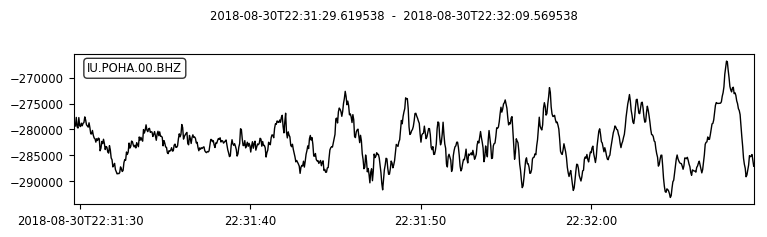

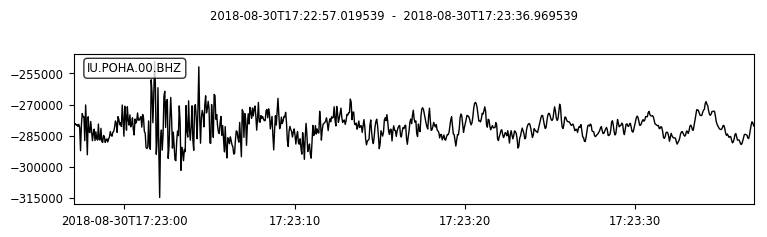

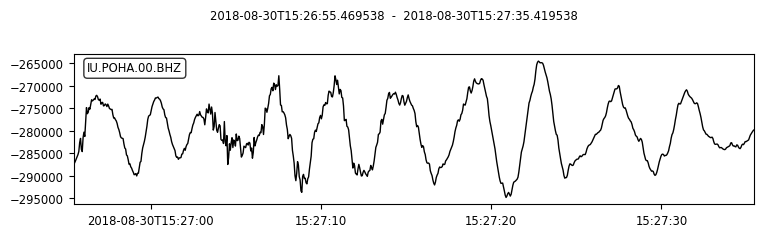

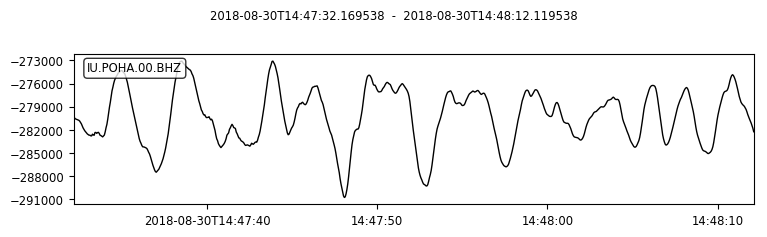

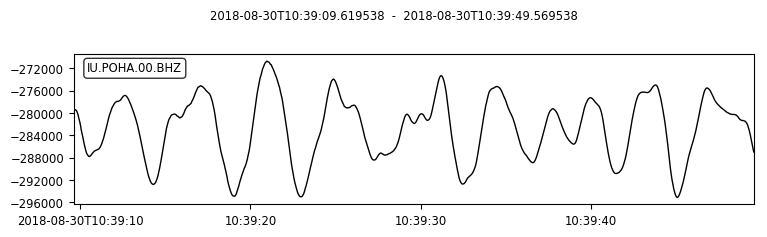

In [8]:
for st in stream[:5]:
    st.plot()

## Do an example preprocessing.  The actual preprocessing happens in the autoencoder notebook.

In [9]:
strcopy = stream.copy()

In [10]:
strcopy.remove_response(POHA)
strcopy.filter('bandpass', freqmin=3, freqmax=8, corners=2, zerophase=True)
strcopy.normalize()

41474 Trace(s) in Stream:

IU.POHA.00.BHZ | 2018-08-30T22:31:29.619538Z - 2018-08-30T22:32:09.569538Z | 20.0 Hz, 800 samples
...
(41472 other traces)
...
IU.POHA.00.BHZ | 2018-04-01T06:52:23.669538Z - 2018-04-01T06:53:03.619538Z | 20.0 Hz, 800 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

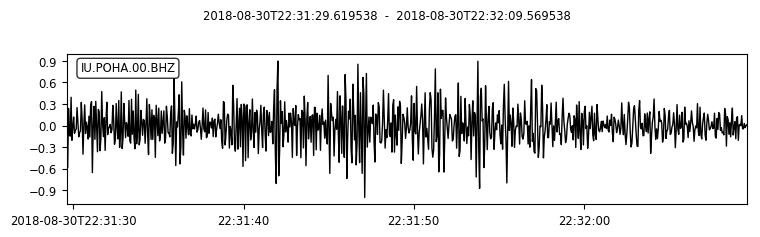

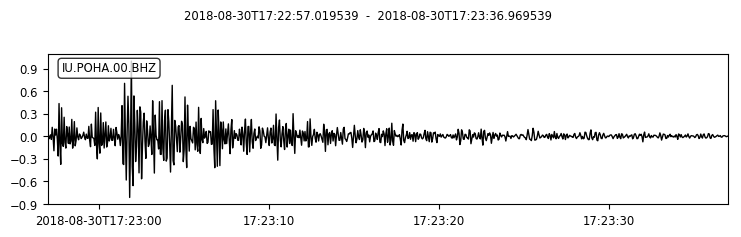

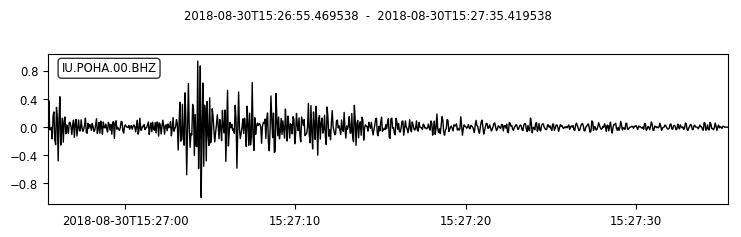

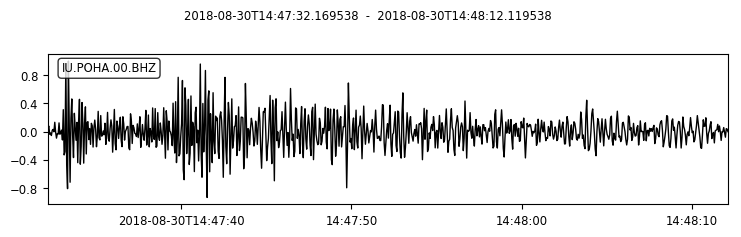

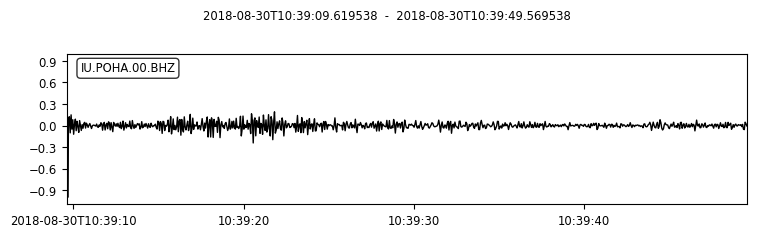

In [11]:
for st in strcopy[:5]:
    st.plot()

## Plot a random sample of the earthquakes

In [12]:
sample = obspy.Catalog([events[i] for i in np.random.randint(low=1, high=len(events)+1, size=1000)])

In [13]:
sample

1000 Event(s) in Catalog:
2018-04-19T07:49:50.030000Z | +19.211, -155.417 | 1.76 Md
2018-07-12T03:03:36.820000Z | +19.415, -155.273 | 2.15 Ml
...
2018-06-23T08:19:56.090000Z | +19.414, -155.282 | 2.35 Ml
2018-06-22T22:21:57.150000Z | +19.424, -155.284 | 2.76 Ml
To see all events call 'print(CatalogObject.__str__(print_all=True))'

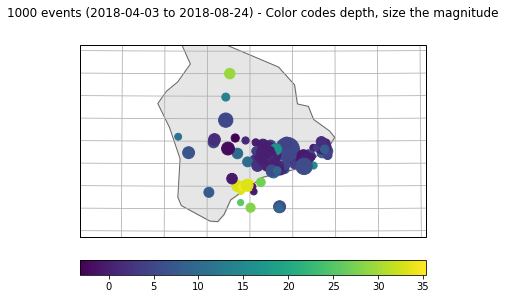

In [14]:
#f, ax = plt.subplots(1, figsize=(20,20))
_=sample.plot(projection='local', resolution='h', label=None)